<a href="https://colab.research.google.com/github/camillabocciolone/Leonardo-project/blob/main/eegpt_vs_fda_correctlypreprocessed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# import necessari librerie e files

## import libraries

In [31]:
!pip -q install einops tqdm scikit-learn scipy

import os, sys, numpy as np, torch
from pathlib import Path
from scipy.signal import resample_poly
from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import os, json
import numpy as np
import pandas as pd

from scipy.signal import butter, filtfilt, iirnotch, resample_poly, detrend
from sklearn.model_selection import GroupKFold, GroupShuffleSplit
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader



## --- Repo EEGPT ---

In [32]:
# (opzionale) aggiorna pip/setuptools/wheel per massimizzare compatibilità
!pip install -U pip setuptools wheel

# install minimo per il tuo script
!pip install numpy scipy scikit-learn einops tqdm

# torch: in Colab di solito è già installato; se no:
!pip install torch --index-url https://download.pytorch.org/whl/cpu



Looking in indexes: https://download.pytorch.org/whl/cpu


## montare il drive

In [33]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Usa il checkpoint direttamente da Drive

In [34]:
from pathlib import Path

ckpt_path = Path(
    "/content/drive/MyDrive/EEGPT/checkpoint/eegpt_mcae_58chs_4s_large4E.ckpt"
)

print("Checkpoint exists:", ckpt_path.exists())


Checkpoint exists: True


## Clona il repo

In [35]:
from pathlib import Path
import os

%cd /content
if not Path("/content/EEGPT").exists():
    !git clone -q https://github.com/BINE022/EEGPT.git

print("Repo OK:", Path("/content/EEGPT").exists())
print("Has downstream:", Path("/content/EEGPT/downstream").exists())


/content
Repo OK: True
Has downstream: True


## Import del modello

In [36]:
import importlib.util
from pathlib import Path

path = Path("/content/EEGPT/downstream/Modules/models/EEGPT_mcae_finetune.py")
print("Model file exists:", path.exists(), path)

spec = importlib.util.spec_from_file_location("eegpt_mcae_finetune", str(path))
mod = importlib.util.module_from_spec(spec)
spec.loader.exec_module(mod)

EEGPTClassifier = mod.EEGPTClassifier
CHANNEL_DICT = mod.CHANNEL_DICT

print("Import OK. CHANNEL_DICT size:", len(CHANNEL_DICT))


Model file exists: True /content/EEGPT/downstream/Modules/models/EEGPT_mcae_finetune.py
Import OK. CHANNEL_DICT size: 62


/content/EEGPT/downstream/Modules/models/EEGPT_mcae_finetune.py:679: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @autocast(True)
/content/EEGPT/downstream/Modules/models/EEGPT_mcae_finetune.py:693: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @autocast(True)


# EEGPT on the true dataset

## ridefiniamo build all usando rec_id

**Scopo**: oltre a subject, crea anche un ID del recording in modo che si possa fare split “a livello di registrazione” (recording-level) e poi prendere tutte le finestre di quella registrazione insieme

In [37]:
data_dir = "/content/drive/My Drive/LL2/LL2/raw_data"

levels = ["highlevel", "midlevel", "lowlevel", "natural"]   # y=0,1,2
tasks  = ["Stroop"]
subjects = range(1, 16)

C = 8
fs_in = 250
FS_OUT = 256
EPOCH_SEC, STRIDE_SEC = 4.0, 2.0
BP_LO, BP_HI = 0.5, 45.0
NOTCH_F0, NOTCH_Q = 50.0, 30.0

# canali OpenBCI (devono essere in CHANNEL_DICT)
my_channels = ["Fp1","Fp2","F7","F3","FZ","F4","F8","C2"]
use_channels_names = [c.upper().strip('.') for c in my_channels]
for c in use_channels_names:
    assert c in CHANNEL_DICT, f"Canale non riconosciuto in CHANNEL_DICT: {c}"
print("Use channels:", use_channels_names)


Use channels: ['FP1', 'FP2', 'F7', 'F3', 'FZ', 'F4', 'F8', 'C2']


In [38]:
LEVEL_TO_Y = {
    "natural":   0,
    "lowlevel":  1,
    "midlevel":  2,
    "highlevel": 2,
}


## definiamo funzioni per la lettura e preprocessing dei dati

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def find_file(level, task, subject):
    # layout A: {level}_Data/{task}-{subject}.txt
    p1 = os.path.join(data_dir, f"{level}_Data", f"{task}-{subject}.txt")
    # layout B: {task}_Data/{level}-{subject}.txt
    p2 = os.path.join(data_dir, f"{task}_Data",  f"{level}-{subject}.txt")
    if os.path.exists(p1): return p1
    if os.path.exists(p2): return p2
    return None

def load_ct_matrix(path, C=8, time_col=22):
    df = pd.read_csv(path, sep=",", header=None, engine="python")
    df = df.iloc[1:, :].reset_index(drop=True)

    # EEG: prime C colonne → (T,C)
    X = df.iloc[:, :C].to_numpy(dtype=np.float32)

    # TIME (se ti serve)
    t = pd.to_numeric(df.iloc[:, time_col], errors="coerce").to_numpy(np.float64)

    return X, t   # X:(T,C)


def bandpass(x, fs, lo=BP_LO, hi=BP_HI, order=4):
    nyq = 0.5 * fs
    b, a = butter(order, [lo/nyq, hi/nyq], btype="band")
    return filtfilt(b, a, x, axis=0)

def notch50(x, fs, f0=NOTCH_F0, Q=NOTCH_Q):
    b, a = iirnotch(w0=f0/(fs/2), Q=Q)
    return filtfilt(b, a, x, axis=0)

def resample_to(x, fs_in, fs_out):
    if fs_in == fs_out:
        return x
    # per 250->256 puoi usare direttamente 128/125
    if int(fs_in)==250 and int(fs_out)==256:
        return resample_poly(x, 128, 125, axis=0)
    # fallback generico
    from math import gcd
    g = gcd(int(fs_in), int(fs_out))
    up, down = fs_out//g, fs_in//g
    return resample_poly(x, up, down, axis=0)

def robust_clip(x, q=0.999):
    hi = np.quantile(x, q, axis=0, keepdims=True)
    lo = np.quantile(x, 1-q, axis=0, keepdims=True)
    return np.clip(x, lo, hi)

def epoch_signal(x_tc, fs, epoch_sec=EPOCH_SEC, stride_sec=STRIDE_SEC):
    # x_tc: (T,C)
    win = int(epoch_sec * fs)
    step = int(stride_sec * fs)
    T = x_tc.shape[0]
    starts = np.arange(0, T - win + 1, step)
    if len(starts)==0:
        return np.empty((0, win, x_tc.shape[1]), dtype=np.float32)
    epochs = np.stack([x_tc[s:s+win] for s in starts], axis=0)  # (N, win, C)
    return epochs


In [40]:
def preprocess_recording(X, t=None, debug=False, ch_idx=0):
    """
    X: (T,C)
    t: (T,) opzionale, NON equidistante
    Ritorna:
      epochs: (N,C,win)
      t_epochs: (N,win) in secondi, equispaziati
    """

    # --- sanity ---
    X = np.asarray(X, dtype=np.float32)
    if X.ndim != 2:
        raise ValueError("X deve essere (T,C)")

    # --- filtri (come prima, ma multi) ---
    x = bandpass(X, fs_in)
    x = notch50(x, fs_in)
    x = detrend(x, axis=0, type="linear")
    x = robust_clip(x, q=0.999)

    # --- resample ---
    x = resample_to(x, fs_in, FS_OUT)   # (T2,C)
    T2, C = x.shape

    # --- tempo COME NEL VECCHIO ---
    # campioni equispaziati, fs fisso
    if t is None:
        t0 = 0.0
    else:
        t = np.asarray(t)
        m = np.isfinite(t)
        t0 = float(t[m][0]) if np.any(m) else 0.0

    t_rs = t0 + np.arange(T2) / FS_OUT   # (T2,)

    # --- epoching A INDICI (IDENTICO AL SINGLE) ---
    win = int(EPOCH_SEC * FS_OUT)
    step = int(STRIDE_SEC * FS_OUT)
    starts = np.arange(0, T2 - win + 1, step)

    if len(starts) == 0:
        return np.empty((0, C, win)), np.empty((0, win))

    epochs = np.stack([x[s:s+win] for s in starts], axis=0)      # (N,win,C)
    epochs = np.transpose(epochs, (0,2,1))                      # (N,C,win)
    t_epochs = np.stack([t_rs[s:s+win] for s in starts], axis=0)

    # --- DEBUG PLOT (DECENTE) ---
    if debug:
        plt.figure(figsize=(12,4))
        plt.plot(
            t_epochs[0] - t_epochs[0,0],
            epochs[0, ch_idx],
            linewidth=0.8
        )
        plt.xlabel("Time (s)")
        plt.title(f"Epoch 0 – channel {ch_idx}")
        plt.grid(alpha=0.2)
        plt.tight_layout()
        plt.show()

    # --- z-score robusto (come prima) ---
    med = np.median(epochs, axis=-1, keepdims=True)
    mad = np.median(np.abs(epochs - med), axis=-1, keepdims=True) + 1e-8
    # epochs = (epochs - med) / (1.4826 * mad)

    return epochs.astype(np.float32), t_epochs



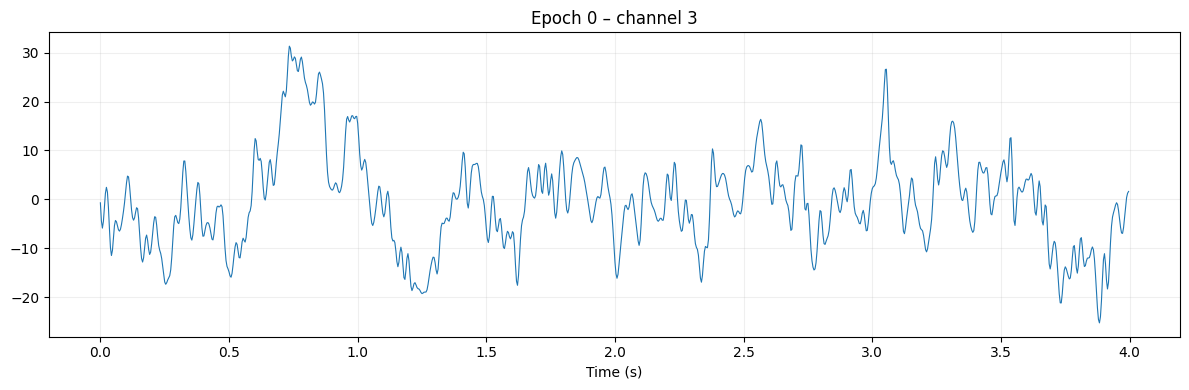

(43, 8, 1024)


In [41]:
task = "Stroop"
level = "highlevel"
subject = 3

path = find_file(level, task, subject)
X, t = load_ct_matrix(path)

epochs, t_epochs = preprocess_recording(
    X, t,
    debug=True,
    ch_idx=3
)

print(epochs.shape)  # (N, C, win)




## build_all

In [43]:
def build_all(levels, tasks, subjects, C=8):
    X_list, y_list, subj_list, rec_list = [], [], [], []
    for li, level in enumerate(levels):
        for task in tasks:
            for s in subjects:
                path = find_file(level, task, s)
                if path is None:
                    print(f"[SKIP] missing file: {level}/{task}/S{s}")
                    continue
                try:

                    X, t = load_ct_matrix(path, C=C)
                    epochs, _ = preprocess_recording(X, t=t)
                    if epochs.shape[0]==0:
                        print(f"[SKIP] no epochs: {os.path.basename(path)}")
                        continue

                    rec_id = f"{task}|{level}|S{s}"
                    X_list.append(epochs)
                    y_list.extend([LEVEL_TO_Y[level]] * len(epochs))
                    subj_list.extend([f"S{s}"]*len(epochs))
                    rec_list.extend([rec_id]*len(epochs))
                except Exception as e:
                    print(f"[ERROR] {os.path.basename(path)}: {e}")
                    continue

    X_all = np.concatenate(X_list, axis=0) if X_list else np.empty((0,C,int(EPOCH_SEC*FS_OUT)), dtype=np.float32)
    y_all = np.array(y_list, dtype=np.int64)
    meta = {
        "subject": np.array(subj_list),
        "rec_id":  np.array(rec_list),
    }
    return X_all, y_all, meta

X_all, y_all, meta = build_all(levels, tasks, subjects, C=8)
print("X_all:", X_all.shape, "y_all:", y_all.shape, "unique rec:", len(np.unique(meta["rec_id"])))


X_all: (2520, 8, 1024) y_all: (2520,) unique rec: 60


## recording-level

Questo blocco serve a fare cross-validation a livello di registrazione (non di finestra), mantenendo l’indipendenza tra soggetti, e poi usare quei recording per selezionare le finestre giuste

In [44]:
print("X_all:", X_all.shape)
print("y_all:", y_all.shape, "meta rec:", meta["rec_id"].shape)
print("unique rec:", len(np.unique(meta["rec_id"])))


X_all: (2520, 8, 1024)
y_all: (2520,) meta rec: (2520,)
unique rec: 60


In [45]:
# Costruisco tabella "recording-level"
rec_ids = np.unique(meta["rec_id"])
rec_to_subject = {rid: rid.split("|")[-1] for rid in rec_ids}  # "...|S7" -> "S7"
rec_subjects = np.array([rec_to_subject[r] for r in rec_ids])

# label per recording: prendo la label della prima finestra di quel rec_id
rec_label = {}
for rid in rec_ids:
    idx = np.where(meta["rec_id"] == rid)[0][0]
    rec_label[rid] = int(y_all[idx])
rec_y = np.array([rec_label[r] for r in rec_ids], dtype=np.int64)

# 5-fold subject-independent sui recording
gkf = GroupKFold(n_splits=5)
folds = []
for trainval_idx, test_idx in gkf.split(rec_ids, rec_y, groups=rec_subjects):
    gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    tr_rel, va_rel = next(gss.split(trainval_idx, groups=rec_subjects[trainval_idx]))
    tr_idx = trainval_idx[tr_rel]
    va_idx = trainval_idx[va_rel]
    folds.append({"train_rec": rec_ids[tr_idx], "val_rec": rec_ids[va_idx], "test_rec": rec_ids[test_idx]})

FOLD = 0
train_rec = set(folds[FOLD]["train_rec"])
val_rec   = set(folds[FOLD]["val_rec"])
test_rec  = set(folds[FOLD]["test_rec"])

print("Fold0 recordings:", len(train_rec), len(val_rec), len(test_rec))


Fold0 recordings: 36 12 12


WindowDataset e i DataLoader fanno solo tre cose:
- selezionano le finestre giuste con la maschera (rec_id ∈ train_rec/val_rec/test_rec)
- tengono in memoria self.X/self.y/self.r
- in __getitem__ trasformano self.X[i] e self.y[i] in tensori torch

In [46]:
class WindowDataset(Dataset):
    def __init__(self, X_all, y_all, rec_id_all, keep_rec_set):
        mask = np.array([rid in keep_rec_set for rid in rec_id_all])
        self.X = X_all[mask]               # (N,C,1024)
        self.y = y_all[mask]
        self.r = rec_id_all[mask]

    def __len__(self): return len(self.y)

    def __getitem__(self, i):
        x = torch.tensor(self.X[i], dtype=torch.float32)  # (8,1024)
        y = torch.tensor(self.y[i], dtype=torch.long)
        rid = self.r[i]
        return x, y, rid

BATCH=64
train_ds = WindowDataset(X_all, y_all, meta["rec_id"], train_rec)
val_ds   = WindowDataset(X_all, y_all, meta["rec_id"], val_rec)
test_ds  = WindowDataset(X_all, y_all, meta["rec_id"], test_rec)

train_loader = DataLoader(train_ds, batch_size=BATCH, shuffle=False)
val_loader   = DataLoader(val_ds, batch_size=BATCH, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=BATCH, shuffle=False)

print("windows:", len(train_ds), len(val_ds), len(test_ds))


windows: 1546 465 509


## definizione modello

In [47]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

my_channels = ["Fp1","Fp2","F7","F3","FZ","F4","F8","C2"]
channels = [c.upper().strip('.') for c in my_channels]

for c in channels:
    assert c in CHANNEL_DICT, f"Canale non riconosciuto: {c}"
print("Channels:", channels)

print("Checkpoint exists:", ckpt_path.exists(), ckpt_path)



Device: cuda
Channels: ['FP1', 'FP2', 'F7', 'F3', 'FZ', 'F4', 'F8', 'C2']
Checkpoint exists: True /content/drive/MyDrive/EEGPT/checkpoint/eegpt_mcae_58chs_4s_large4E.ckpt


In [48]:
# lista 58 canali nell'ordine corretto (ordinati per indice)
inv = {idx: name for name, idx in CHANNEL_DICT.items()}
print(inv)
channels_58 = []
missing = []
for i in range(58):
    if i in inv:
        channels_58.append(inv[i])
    else:
        missing.append(i)

print("len(channels_58) =", len(channels_58))
print("missing idx:", missing)
print("first 10:", channels_58[:10])


model = EEGPTClassifier(
    num_classes=3,
    in_channels=58,
    img_size=[58, 1024],
    patch_stride=128,
    desired_time_len=1024,
    use_channels_names=channels_58,
    ckpt_path=str(ckpt_path),
).to(device)

model.eval()
for p in model.parameters():
    p.requires_grad = False
print("Model ready.")




{0: 'FP1', 1: 'FPZ', 2: 'FP2', 3: 'AF7', 4: 'AF3', 5: 'AF4', 6: 'AF8', 7: 'F7', 8: 'F5', 9: 'F3', 10: 'F1', 11: 'FZ', 12: 'F2', 13: 'F4', 14: 'F6', 15: 'F8', 16: 'FT7', 17: 'FC5', 18: 'FC3', 19: 'FC1', 20: 'FCZ', 21: 'FC2', 22: 'FC4', 23: 'FC6', 24: 'FT8', 25: 'T7', 26: 'C5', 27: 'C3', 28: 'C1', 29: 'CZ', 30: 'C2', 31: 'C4', 32: 'C6', 33: 'T8', 34: 'TP7', 35: 'CP5', 36: 'CP3', 37: 'CP1', 38: 'CPZ', 39: 'CP2', 40: 'CP4', 41: 'CP6', 42: 'TP8', 43: 'P7', 44: 'P5', 45: 'P3', 46: 'P1', 47: 'PZ', 48: 'P2', 49: 'P4', 50: 'P6', 51: 'P8', 52: 'PO7', 53: 'PO5', 54: 'PO3', 55: 'POZ', 56: 'PO4', 57: 'PO6', 58: 'PO8', 59: 'O1', 60: 'OZ', 61: 'O2'}
len(channels_58) = 58
missing idx: []
first 10: ['FP1', 'FPZ', 'FP2', 'AF7', 'AF3', 'AF4', 'AF8', 'F7', 'F5', 'F3']
Model ready.


## creazione di canali fittizzi a 0

In [49]:
# i tuoi 8 canali (devono essere presenti in CHANNEL_DICT)
my_channels = ["Fp1","Fp2","F7","F3","FZ","F4","F8","C2"]
use_channels_8 = [c.upper().strip('.') for c in my_channels]
chan_ids_8 = [CHANNEL_DICT[c] for c in use_channels_8]
print("chan_ids_8:", chan_ids_8)

def embed_8_to_58(xb_8):
    """
    xb_8: (B,8,1024) -> (B,58,1024) con zero-fill
    """
    B, C8, T = xb_8.shape
    xb_58 = torch.zeros(B, 58, T, device=xb_8.device, dtype=xb_8.dtype)
    xb_58[:, chan_ids_8, :] = xb_8
    return xb_58

@torch.no_grad()
def extract_eegpt_features(loader):
    feats_all, y_all, rec_all = [], [], []
    for xb, yb, rid in loader:
        xb = xb.to(device).float()            # (B,8,1024)
        xb58 = embed_8_to_58(xb)              # (B,58,1024)

        feats = model.forward_features(xb58)  # (B,D)
        feats_all.append(feats.cpu())
        y_all.append(yb.cpu())
        rec_all.extend(list(rid))

    return torch.cat(feats_all, 0), torch.cat(y_all, 0), np.array(rec_all)

tr_feat, tr_y, tr_rec = extract_eegpt_features(train_loader)
va_feat, va_y, va_rec = extract_eegpt_features(val_loader)
te_feat, te_y, te_rec = extract_eegpt_features(test_loader)

print("feat shapes:", tr_feat.shape, va_feat.shape, te_feat.shape)

torch.save({
    "tr_feat": tr_feat, "tr_y": tr_y, "tr_rec": tr_rec,
    "va_feat": va_feat, "va_y": va_y, "va_rec": va_rec,
    "te_feat": te_feat, "te_y": te_y, "te_rec": te_rec,
}, "eegpt_window_features_fold0.pt")
print("saved: eegpt_window_features_fold0.pt")


chan_ids_8: [0, 2, 7, 9, 11, 13, 15, 30]
feat shapes: torch.Size([1546, 512]) torch.Size([465, 512]) torch.Size([509, 512])
saved: eegpt_window_features_fold0.pt


## LOSO

In [50]:
num_classes=3
# =======================
# LOSO (Leave-One-Subject-Out) evaluation
# - split by subject
# - extract EEGPT features with 8->58 zero-fill channels
# - pool by recording (mean)
# - train MLP from scratch each LOSO iteration (with a val split inside train)
# - accumulate predictions -> final confusion matrix
# =======================

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report

# ------------------------------------------------------------
# 0) ASSUMPTIONS: you already have these from your notebook
# ------------------------------------------------------------
# - X_all: (Nwin, 8, 1024)  numpy float32
# - y_all: (Nwin,)         numpy int64
# - meta["rec_id"]: (Nwin,) array of strings like "task|level|S3"
# - meta["subject"]: (Nwin,) array of strings like "S3"
# - model: EEGPT model already loaded, on device, with .forward_features(x58)->(B,D)
# - chan_ids_8: list of 8 indices in [0..57] corresponding to your channels
# - num_classes = 3
# - BATCH = 64

# If any of these are named differently in your notebook, just rename accordingly.

# ------------------------------------------------------------
# 1) Dataset (same logic you already used)
# ------------------------------------------------------------
class WindowDataset(Dataset):
    def __init__(self, X_all, y_all, rec_id_all, keep_rec_set):
        mask = np.array([rid in keep_rec_set for rid in rec_id_all], dtype=bool)
        self.X = X_all[mask]           # (N,C,T)
        self.y = y_all[mask]           # (N,)
        self.r = np.asarray(rec_id_all)[mask]  # (N,)
    def __len__(self):
        return len(self.y)
    def __getitem__(self, i):
        x = torch.tensor(self.X[i], dtype=torch.float32)  # (8,1024)
        y = torch.tensor(self.y[i], dtype=torch.long)
        rid = self.r[i]
        return x, y, rid

# ------------------------------------------------------------
# 2) 8 -> 58 zero-fill adapter (THIS is where channels are "filled")
# ------------------------------------------------------------
def embed_8_to_58(xb_8, chan_ids_8):
    """
    xb_8: (B,8,1024) -> xb_58: (B,58,1024) with zeros elsewhere
    """
    B, C8, T = xb_8.shape
    xb_58 = torch.zeros(B, 58, T, device=xb_8.device, dtype=xb_8.dtype)
    xb_58[:, chan_ids_8, :] = xb_8
    return xb_58

# ------------------------------------------------------------
# 3) Feature extraction (channels are filled HERE, before EEGPT)
# ------------------------------------------------------------
@torch.no_grad()
def extract_eegpt_features(model, loader, device, chan_ids_8):
    feats_all, y_all_out, rec_all = [], [], []
    for xb, yb, rid in loader:
        xb = xb.to(device).float()                 # (B,8,1024)
        xb58 = embed_8_to_58(xb, chan_ids_8)       # (B,58,1024)  <--- fill happens here
        feats = model.forward_features(xb58)       # (B,D)
        feats_all.append(feats.detach().cpu())
        y_all_out.append(yb.detach().cpu())
        rec_all.extend(list(rid))
    return torch.cat(feats_all, 0), torch.cat(y_all_out, 0), np.asarray(rec_all).astype(str)

# ------------------------------------------------------------
# 4) Pool by recording (mean)
# ------------------------------------------------------------
def pool_by_recording_torch(feat, y, rec):
    """
    feat: torch (Nwin, D)
    y   : torch (Nwin,)
    rec : np.array str (Nwin,)
    returns:
      X_rec: torch (Nrec, D)
      y_rec: torch (Nrec,)
      rec_uniq: np.array str (Nrec,)
    """
    rec = np.asarray(rec).astype(str)
    uniq = np.unique(rec)
    Xr, Yr = [], []
    for rid in uniq:
        m = (rec == rid)
        Xr.append(feat[m].mean(dim=0))
        Yr.append(int(y[m][0].item()))
    return torch.stack(Xr, 0), torch.tensor(Yr, dtype=torch.long), uniq

# ------------------------------------------------------------
# 5) MLP classifier
# ------------------------------------------------------------
class MLP(nn.Module):
    def __init__(self, d_in, n_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d_in, 256), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(256, 128), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(128, n_classes),
        )
    def forward(self, x):
        return self.net(x)

def train_mlp_with_val(Xtr_np, ytr_np, Xva_np, yva_np, num_classes, device,
                       max_epochs=300, patience=30, lr=1e-3, wd=1e-4):
    """
    X* are numpy arrays (N, D), y* are numpy (N,)
    returns trained clf
    """
    Xtr = torch.tensor(Xtr_np, dtype=torch.float32).to(device)
    Xva = torch.tensor(Xva_np, dtype=torch.float32).to(device)
    ytr = torch.tensor(ytr_np, dtype=torch.long).to(device)
    yva = torch.tensor(yva_np, dtype=torch.long).to(device)

    clf = MLP(Xtr.shape[1], num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    opt = optim.AdamW(clf.parameters(), lr=lr, weight_decay=wd)

    @torch.no_grad()
    def eval_acc(X, y):
        clf.eval()
        pred = clf(X).argmax(1)
        return (pred == y).float().mean().item()

    best_va = -1
    best_state = None
    noimp = 0

    for epoch in range(1, max_epochs + 1):
        clf.train()
        opt.zero_grad(set_to_none=True)
        logits = clf(Xtr)
        loss = criterion(logits, ytr)
        loss.backward()
        opt.step()

        va_acc = eval_acc(Xva, yva)
        if va_acc > best_va:
            best_va = va_acc
            best_state = {k: v.detach().cpu().clone() for k, v in clf.state_dict().items()}
            noimp = 0
        else:
            noimp += 1

        if noimp >= patience:
            break

    if best_state is not None:
        clf.load_state_dict(best_state)

    return clf

# ------------------------------------------------------------
# 6) LOSO main loop
# ------------------------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

subjects = np.unique(meta["subject"].astype(str))
rec_ids_all = meta["rec_id"].astype(str)
subj_all = meta["subject"].astype(str)

all_true = []
all_pred = []

for s in subjects:
    # test = all recordings of subject s
    test_rec = set(rec_ids_all[subj_all == s])
    trainval_rec = set(rec_ids_all[subj_all != s])

    # ---- split trainval into train/val by recording, grouped by subject (still excluding s)
    trainval_rec_list = np.array(sorted(list(trainval_rec)))
    trainval_subj_list = np.array([rid.split("|")[-1] for rid in trainval_rec_list])  # "...|S7" -> "S7"

    gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    tr_idx, va_idx = next(gss.split(trainval_rec_list, groups=trainval_subj_list))
    train_rec = set(trainval_rec_list[tr_idx])
    val_rec   = set(trainval_rec_list[va_idx])

    # ---- datasets/loaders (WINDOW level)
    train_ds = WindowDataset(X_all, y_all, rec_ids_all, train_rec)
    val_ds   = WindowDataset(X_all, y_all, rec_ids_all, val_rec)
    test_ds  = WindowDataset(X_all, y_all, rec_ids_all, test_rec)

    train_loader = DataLoader(train_ds, batch_size=BATCH, shuffle=False)
    val_loader   = DataLoader(val_ds,   batch_size=BATCH, shuffle=False)
    test_loader  = DataLoader(test_ds,  batch_size=BATCH, shuffle=False)

    # ---- EEGPT feature extraction (channels filled inside)
    tr_feat, tr_y, tr_rec = extract_eegpt_features(model, train_loader, device, chan_ids_8)
    va_feat, va_y, va_rec = extract_eegpt_features(model, val_loader,   device, chan_ids_8)
    te_feat, te_y, te_rec = extract_eegpt_features(model, test_loader,  device, chan_ids_8)

    # ---- pool by recording (RECORDING level)
    X_tr, y_tr, _ = pool_by_recording_torch(tr_feat, tr_y, tr_rec)
    X_va, y_va, _ = pool_by_recording_torch(va_feat, va_y, va_rec)
    X_te, y_te, _ = pool_by_recording_torch(te_feat, te_y, te_rec)

    # ---- scaler fit on TRAIN recordings only
    scaler = StandardScaler()
    X_tr_np = scaler.fit_transform(X_tr.numpy())
    X_va_np = scaler.transform(X_va.numpy())
    X_te_np = scaler.transform(X_te.numpy())

    # ---- train MLP with val
    clf = train_mlp_with_val(X_tr_np, y_tr.numpy(), X_va_np, y_va.numpy(),
                             num_classes=num_classes, device=device)

    # ---- predict on test subject recordings
    with torch.no_grad():
        clf.eval()
        Xte_t = torch.tensor(X_te_np, dtype=torch.float32).to(device)
        te_pred = clf(Xte_t).argmax(1).cpu().numpy()

    # ---- accumulate for global LOSO confusion matrix
    all_true.extend(y_te.cpu().numpy().tolist())
    all_pred.extend(te_pred.tolist())

# ------------------------------------------------------------
# 7) Final global confusion matrix (LOSO)
# ------------------------------------------------------------
cm = confusion_matrix(all_true, all_pred)
print("LOSO Confusion matrix:\n", cm)
print("\nLOSO Report:\n", classification_report(all_true, all_pred, digits=3))


LOSO Confusion matrix:
 [[ 7  1  7]
 [ 1  3 11]
 [ 1  6 23]]

LOSO Report:
               precision    recall  f1-score   support

           0      0.778     0.467     0.583        15
           1      0.300     0.200     0.240        15
           2      0.561     0.767     0.648        30

    accuracy                          0.550        60
   macro avg      0.546     0.478     0.490        60
weighted avg      0.550     0.550     0.530        60



## t-sne + confusion matrix

dict_keys(['tr_feat', 'tr_y', 'tr_rec', 'va_feat', 'va_y', 'va_rec', 'te_feat', 'te_y', 'te_rec'])
WINDOW shapes: torch.Size([1546, 512]) torch.Size([465, 512]) torch.Size([509, 512])
unique rec counts: 36 12 12
TSN shapes: torch.Size([36, 512]) torch.Size([12, 512]) torch.Size([12, 512])
num_classes: 3
epoch 001 | loss=1.127 | tr_acc=0.278 | va_acc=0.417 | best_va=0.417
Early stop.

TEST acc: 0.3333333432674408
Confusion matrix:
 [[2 1 0]
 [1 0 2]
 [0 4 2]]

Report:
               precision    recall  f1-score   support

           0      0.667     0.667     0.667         3
           1      0.000     0.000     0.000         3
           2      0.500     0.333     0.400         6

    accuracy                          0.333        12
   macro avg      0.389     0.333     0.356        12
weighted avg      0.417     0.333     0.367        12



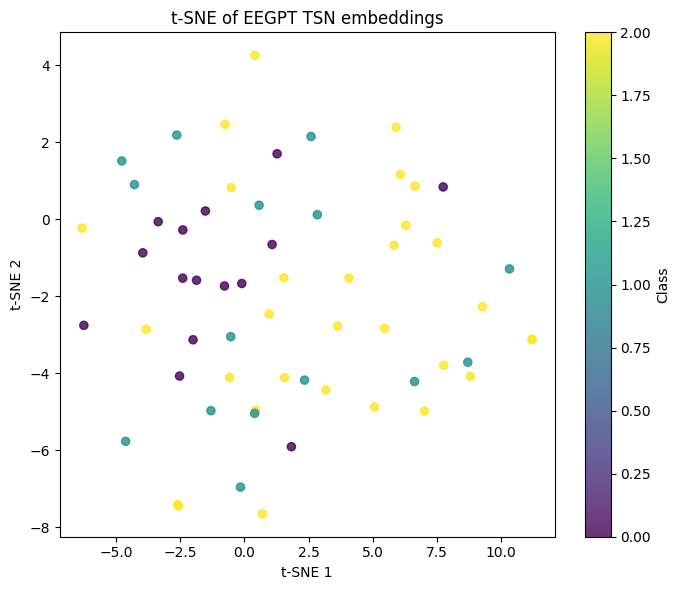

In [53]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# ========== 1) LOAD WINDOW FEATURES ==========

data = torch.load("eegpt_window_features_fold0.pt", map_location="cpu", weights_only=False)
print(data.keys())


tr_feat = data["tr_feat"]  # torch (Nwin, D)
tr_y    = data["tr_y"]     # torch (Nwin,)
tr_rec  = data["tr_rec"]   # numpy o list

va_feat = data["va_feat"]
va_y    = data["va_y"]
va_rec  = data["va_rec"]

te_feat = data["te_feat"]
te_y    = data["te_y"]
te_rec  = data["te_rec"]

print("WINDOW shapes:", tr_feat.shape, va_feat.shape, te_feat.shape)

# ========== 2) FIX rec_id in modo robusto ==========
def to_numpy_ids(rec):
    # rec può essere numpy array, lista, tensor…
    if isinstance(rec, torch.Tensor):
        rec = rec.cpu().numpy()
    rec = np.asarray(rec)

    # se è dtype=object o stringhe, lo trasformo in codici interi stabili
    if rec.dtype == object or rec.dtype.kind in ("U", "S"):
        uniq, inv = np.unique(rec.astype(str), return_inverse=True)
        return inv.astype(np.int64)
    return rec.astype(np.int64)

tr_rec = to_numpy_ids(tr_rec)
va_rec = to_numpy_ids(va_rec)
te_rec = to_numpy_ids(te_rec)

print("unique rec counts:", len(np.unique(tr_rec)), len(np.unique(va_rec)), len(np.unique(te_rec)))

# ========== 3) TSN pooling (mean) ==========
def tsn_pool(feat, y, rec):
    uniq = np.unique(rec)
    X, Y = [], []
    for rid in uniq:
        m = (rec == rid)
        X.append(feat[m].mean(dim=0))
        Y.append(int(y[m][0].item()))
    return torch.stack(X), torch.tensor(Y, dtype=torch.long)

X_tr, y_tr = tsn_pool(tr_feat, tr_y, tr_rec)
X_va, y_va = tsn_pool(va_feat, va_y, va_rec)
X_te, y_te = tsn_pool(te_feat, te_y, te_rec)

print("TSN shapes:", X_tr.shape, X_va.shape, X_te.shape)
num_classes = int(3)
print("num_classes:", num_classes)

# ========== 4) StandardScaler (fit su train) ==========
scaler = StandardScaler()
X_tr_np = scaler.fit_transform(X_tr.numpy())
X_va_np = scaler.transform(X_va.numpy())
X_te_np = scaler.transform(X_te.numpy())

Xtr = torch.tensor(X_tr_np, dtype=torch.float32)
Xva = torch.tensor(X_va_np, dtype=torch.float32)
Xte = torch.tensor(X_te_np, dtype=torch.float32)

# ========== 5) MLP classifier ==========
class MLP(nn.Module):
    def __init__(self, d_in, n_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d_in, 256), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(256, 128), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(128, n_classes),
        )
    def forward(self, x): return self.net(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
clf = MLP(Xtr.shape[1], num_classes).to(device)

criterion = nn.CrossEntropyLoss()
opt = optim.AdamW(clf.parameters(), lr=1e-3, weight_decay=1e-4)

Xtr, y_tr = Xtr.to(device), y_tr.to(device)
Xva, y_va = Xva.to(device), y_va.to(device)
Xte, y_te = Xte.to(device), y_te.to(device)

@torch.no_grad()
def acc_and_pred(X, y):
    clf.eval()
    logits = clf(X)
    pred = logits.argmax(1)
    acc = (pred == y).float().mean().item()
    return acc, pred.detach().cpu().numpy()

best_va = -1
best_state = None
patience = 30
noimp = 0

for epoch in range(1, 301):
    clf.train()
    opt.zero_grad(set_to_none=True)
    logits = clf(Xtr)
    loss = criterion(logits, y_tr)
    loss.backward()
    opt.step()

    va_acc, _ = acc_and_pred(Xva, y_va)

    if va_acc > best_va:
        best_va = va_acc
        best_state = {k: v.detach().cpu().clone() for k, v in clf.state_dict().items()}
        noimp = 0
    else:
        noimp += 1

    if epoch % 50 == 0 or epoch == 1:
        tr_acc = (logits.argmax(1) == y_tr).float().mean().item()
        print(f"epoch {epoch:03d} | loss={loss.item():.3f} | tr_acc={tr_acc:.3f} | va_acc={va_acc:.3f} | best_va={best_va:.3f}")

    if noimp >= patience:
        print("Early stop.")
        break

if best_state is not None:
    clf.load_state_dict(best_state)

# ========== 6) TEST: confusion matrix ==========
te_acc, te_pred = acc_and_pred(Xte, y_te)
print("\nTEST acc:", te_acc)

cm = confusion_matrix(y_te.cpu().numpy(), te_pred)
print("Confusion matrix:\n", cm)
print("\nReport:\n", classification_report(y_te.cpu().numpy(), te_pred, digits=3))

# ========== 7) t-SNE plot (TSN embeddings) ==========
X_emb_all = np.concatenate([X_tr_np, X_va_np, X_te_np], axis=0)
y_emb_all = np.concatenate([y_tr.cpu().numpy(), y_va.cpu().numpy(), y_te.cpu().numpy()], axis=0)


X_pca = PCA(n_components=min(30, X_emb_all.shape[1]), random_state=0).fit_transform(X_emb_all)
perp = min(15, max(5, len(X_emb_all) // 4))

tsne = TSNE(
    n_components=2,
    perplexity=perp,
    init="pca",
    learning_rate="auto",
    random_state=0
)
X_2d = tsne.fit_transform(X_pca)

plt.figure(figsize=(7,6))
sc = plt.scatter(X_2d[:,0], X_2d[:,1], c=y_emb_all, s=35, alpha=0.8)
plt.colorbar(sc, label="Class")
plt.title("t-SNE of EEGPT TSN embeddings")
plt.xlabel("t-SNE 1"); plt.ylabel("t-SNE 2")
plt.tight_layout()
plt.show()



Questa cella serve a “guardare dentro” le feature finali, proiettandole in 2D per vedere se le classi si separano davvero o no cambiando il seed


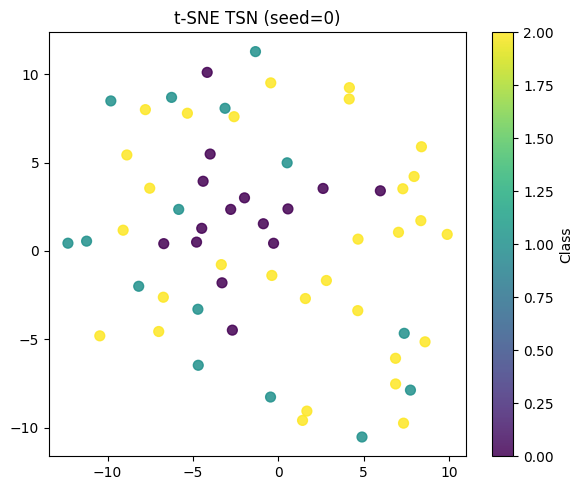

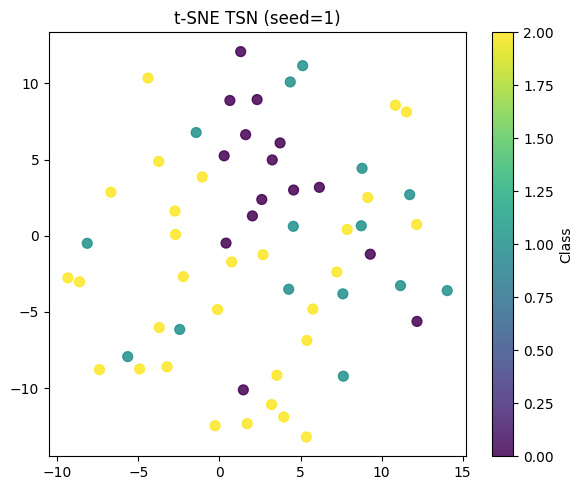

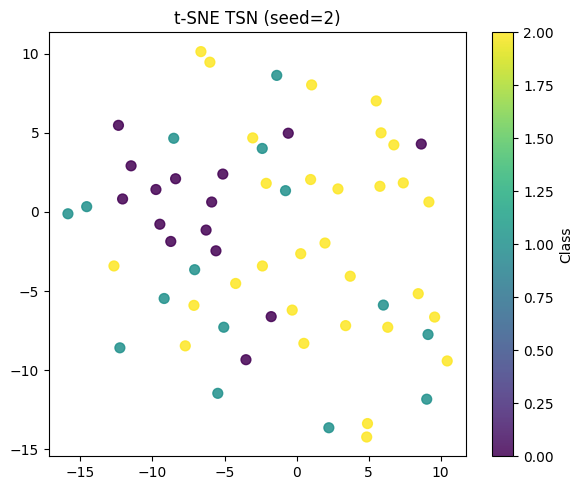

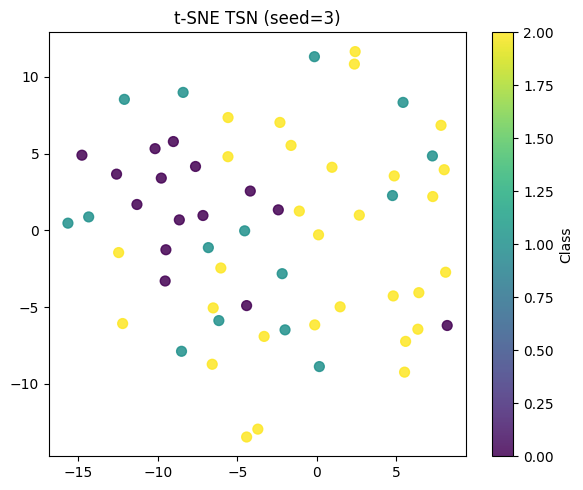

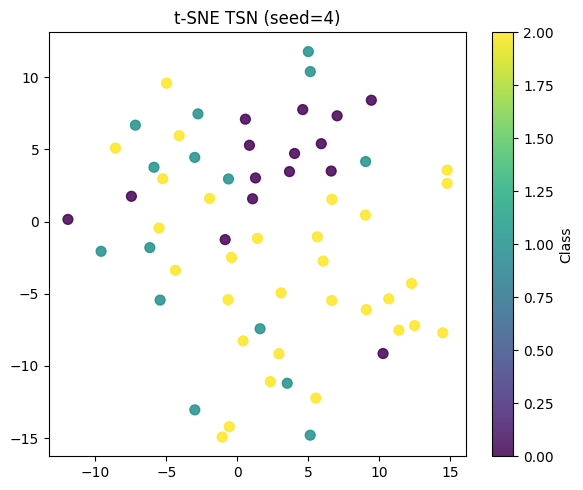

In [54]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

X = torch.cat([X_tr, X_va, X_te], dim=0).cpu().numpy()
y = torch.cat([y_tr, y_va, y_te], dim=0).cpu().numpy()


# standardizza
Xz = StandardScaler().fit_transform(X)

# PCA
Xp = PCA(n_components=min(30, Xz.shape[1]), random_state=0).fit_transform(Xz)

# t-SNE con più seed
for seed in [0,1,2,3,4]:
    tsne = TSNE(
        n_components=2,
        perplexity=10,
        init="pca",
        learning_rate="auto",
        random_state=seed
    )
    X2 = tsne.fit_transform(Xp)

    plt.figure(figsize=(6,5))
    plt.scatter(X2[:,0], X2[:,1], c=y, s=50, alpha=0.85)
    plt.title(f"t-SNE TSN (seed={seed})")
    plt.colorbar(label="Class")
    plt.tight_layout()
    plt.show()



/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computing 46 nearest neighbors...
[t-SNE] Indexed 800 samples in 0.004s...
[t-SNE] Computed neighbors for 800 samples in 0.057s...
[t-SNE] Computed conditional probabilities for sample 800 / 800
[t-SNE] Mean sigma: 6.242623
[t-SNE] KL divergence after 250 iterations with early exaggeration: 74.341232
[t-SNE] KL divergence after 750 iterations: 1.744560


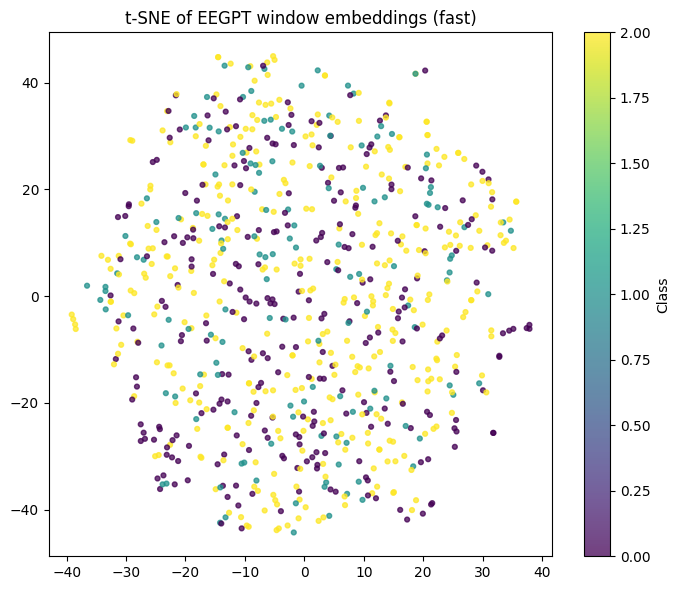

In [55]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

data = torch.load("eegpt_window_features_fold0.pt", map_location="cpu", weights_only=False)

Xw_all = data["tr_feat"].numpy()
yw_all = data["tr_y"].numpy()

# subsample aggressivo
max_points = 800
rs = np.random.RandomState(0)
idx = rs.choice(len(Xw_all), size=min(max_points, len(Xw_all)), replace=False)
Xw = Xw_all[idx]
yw = yw_all[idx]

Xz = StandardScaler().fit_transform(Xw)
Xp = PCA(n_components=15, random_state=0).fit_transform(Xz)

tsne = TSNE(
    n_components=2,
    perplexity=15,
    init="pca",
    learning_rate="auto",
    random_state=0,
    n_iter=750,
    method="barnes_hut",
    verbose=1
)
X2 = tsne.fit_transform(Xp)

plt.figure(figsize=(7,6))
plt.scatter(X2[:,0], X2[:,1], c=yw, s=12, alpha=0.75)
plt.title("t-SNE of EEGPT window embeddings (fast)")
plt.colorbar(label="Class")
plt.tight_layout()
plt.show()


# FDA

## A) Helper: estrarre finestre e rec_id dal Dataset (senza torch)

In [56]:
import numpy as np

def get_numpy_from_ds(ds):
    """
    ds: WindowDataset
    returns:
      X: (Nwin, C, T) float32
      y: (Nwin,) int64
      rec: (Nwin,) array dtype object/str
    """
    X = ds.X.astype(np.float32)
    y = ds.y.astype(np.int64)
    rec = np.asarray(ds.r)
    return X, y, rec


## B) Pooling per recording (uguale al tuo TSN pooling, ma numpy)

In [57]:
def pool_by_recording(X_feat, y_win, rec_ids, agg="mean"):
    """
    X_feat: (Nwin, p)
    y_win : (Nwin,)
    rec_ids: (Nwin,) strings or objects
    returns:
      X_rec: (Nrec, p)
      y_rec: (Nrec,)
      rec_uniq: (Nrec,)
    """
    rec_ids = np.asarray(rec_ids).astype(str)
    uniq = np.unique(rec_ids)
    Xr, Yr = [], []
    for rid in uniq:
        m = (rec_ids == rid)
        if agg == "mean":
            Xr.append(X_feat[m].mean(axis=0))
        elif agg == "median":
            Xr.append(np.median(X_feat[m], axis=0))
        else:
            raise ValueError("agg must be mean or median")
        Yr.append(int(y_win[m][0]))
    return np.stack(Xr, axis=0), np.asarray(Yr, dtype=np.int64), uniq


## C) FDA baseline = “curve features” + PCA
Qui scegliamo due varianti:
1) PCA per-canale

    input: finestre (Nwin, 8, 1024)

    per ogni canale k: PCA su (Nwin, 1024)

    prendi K score

    concateni ⇒ (Nwin, 8K)
2) PCA globale

    appiattisci window → (Nwin, 8*1024)

    PCA globale, prendi K ⇒ (Nwin, K)

In [58]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def make_fda_features_per_channel(Xtr, Xva, Xte, K=8, center=True):
    """
    X*: (Nwin, C, T)
    returns features:
      Ftr: (Nwin_tr, C*K)
      Fva: (Nwin_va, C*K)
      Fte: (Nwin_te, C*K)
    """
    C, T = Xtr.shape[1], Xtr.shape[2]
    Ftr_list, Fva_list, Fte_list = [], [], []
    pca_list = []
    for k in range(C):
        Ytr = Xtr[:, k, :]  # (Ntr, T)
        Yva = Xva[:, k, :]
        Yte = Xte[:, k, :]

        # opzionale: centra (PCA con center=True già lo fa)
        pca = PCA(n_components=K, random_state=0)
        pca.fit(Ytr)  # FIT SOLO SU TRAIN
        pca_list.append(pca)

        Ftr_list.append(pca.transform(Ytr))
        Fva_list.append(pca.transform(Yva))
        Fte_list.append(pca.transform(Yte))

    Ftr = np.concatenate(Ftr_list, axis=1)
    Fva = np.concatenate(Fva_list, axis=1)
    Fte = np.concatenate(Fte_list, axis=1)
    return Ftr.astype(np.float32), Fva.astype(np.float32), Fte.astype(np.float32), pca_list

def make_fda_features_global(Xtr, Xva, Xte, K=32):
    """
    Flatten (C,T)->(C*T) then PCA on train
    """
    Ntr, C, T = Xtr.shape
    Ztr = Xtr.reshape(Ntr, C*T)
    Zva = Xva.reshape(Xva.shape[0], C*T)
    Zte = Xte.reshape(Xte.shape[0], C*T)

    pca = PCA(n_components=K, random_state=0)
    pca.fit(Ztr)  # FIT SOLO SU TRAIN

    Ftr = pca.transform(Ztr).astype(np.float32)
    Fva = pca.transform(Zva).astype(np.float32)
    Fte = pca.transform(Zte).astype(np.float32)
    return Ftr, Fva, Fte, pca


## D) Allinea il tuo “protocollo EEGPT”: pooling per recording + scaler + MLP

In [59]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import confusion_matrix, classification_report

class MLP(nn.Module):
    def __init__(self, d_in, n_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d_in, 256), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(256, 128), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(128, n_classes),
        )
    def forward(self, x): return self.net(x)

def train_mlp_recordlevel(Xtr_rec, ytr_rec, Xva_rec, yva_rec, Xte_rec, yte_rec,
                          num_classes, max_epochs=300, patience=30, lr=1e-3, wd=1e-4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # scaler fit su train
    scaler = StandardScaler()
    Xtr_np = scaler.fit_transform(Xtr_rec)
    Xva_np = scaler.transform(Xva_rec)
    Xte_np = scaler.transform(Xte_rec)

    Xtr = torch.tensor(Xtr_np, dtype=torch.float32).to(device)
    Xva = torch.tensor(Xva_np, dtype=torch.float32).to(device)
    Xte = torch.tensor(Xte_np, dtype=torch.float32).to(device)
    ytr = torch.tensor(ytr_rec, dtype=torch.long).to(device)
    yva = torch.tensor(yva_rec, dtype=torch.long).to(device)
    yte = torch.tensor(yte_rec, dtype=torch.long).to(device)

    clf = MLP(Xtr.shape[1], num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    opt = optim.AdamW(clf.parameters(), lr=lr, weight_decay=wd)

    @torch.no_grad()
    def eval_acc(X, y):
        clf.eval()
        pred = clf(X).argmax(1)
        return (pred == y).float().mean().item(), pred.detach().cpu().numpy()

    best_va = -1
    best_state = None
    noimp = 0

    for epoch in range(1, max_epochs+1):
        clf.train()
        opt.zero_grad(set_to_none=True)
        logits = clf(Xtr)
        loss = criterion(logits, ytr)
        loss.backward()
        opt.step()

        va_acc, _ = eval_acc(Xva, yva)
        if va_acc > best_va:
            best_va = va_acc
            best_state = {k: v.detach().cpu().clone() for k, v in clf.state_dict().items()}
            noimp = 0
        else:
            noimp += 1

        if epoch % 50 == 0 or epoch == 1:
            tr_acc = (logits.argmax(1) == ytr).float().mean().item()
            print(f"epoch {epoch:03d} | loss={loss.item():.3f} | tr_acc={tr_acc:.3f} | va_acc={va_acc:.3f} | best_va={best_va:.3f}")

        if noimp >= patience:
            print("Early stop.")
            break

    if best_state is not None:
        clf.load_state_dict(best_state)

    te_acc, te_pred = eval_acc(Xte, yte)
    print("\nTEST acc:", te_acc)
    cm = confusion_matrix(yte_rec, te_pred)
    print("Confusion matrix:\n", cm)
    print("\nReport:\n", classification_report(yte_rec, te_pred, digits=3))
    return te_acc, cm


In [60]:
import numpy as np
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import confusion_matrix, classification_report

# =========================
# 0) Window-level "source of truth"
# =========================
X_win_all = X_all          # DEVE essere (Nwin, 8, 1024)
y_win_all = y_all          # DEVE essere (Nwin,)
rec_id_win = meta["rec_id"].astype(str)
subj_win   = meta["subject"].astype(str)

assert X_win_all.shape[0] == len(y_win_all) == len(rec_id_win) == len(subj_win), \
    "Mismatch: assicurati che X_win_all/y_win_all/meta siano window-level!"

num_classes = 3

# =========================
# 1) Ricavo lista recording (60) + subject per recording
# =========================
rec_ids = np.unique(rec_id_win)  # 60
rec_subjects = np.array([rid.split("|")[-1] for rid in rec_ids])  # "...|S7" -> "S7"
subjects = np.unique(rec_subjects)

# =========================
# 2) WindowDataset (uguale al tuo)
# =========================
from torch.utils.data import Dataset

class WindowDataset(Dataset):
    def __init__(self, X_all, y_all, rec_id_all, keep_rec_set):
        mask = np.array([rid in keep_rec_set for rid in rec_id_all], dtype=bool)
        self.X = X_all[mask]
        self.y = y_all[mask]
        self.r = np.asarray(rec_id_all)[mask]
    def __len__(self): return len(self.y)
    def __getitem__(self, i):
        # qui non serve torch: ma la tua get_numpy_from_ds usa ds.X/ds.y/ds.r direttamente
        return self.X[i], self.y[i], self.r[i]

# =========================
# 3) LOSO loop: FDA per-channel + FDA global
#    Accumulo predizioni e faccio CM finale
# =========================
all_true_ch, all_pred_ch = [], []
all_true_g,  all_pred_g  = [], []

K_ch   = 8
K_glob = 64

for s in subjects:
    # --- split recording-level: test subject s
    test_rec = set(rec_ids[rec_subjects == s])
    trainval_rec = rec_ids[rec_subjects != s]
    trainval_subjects = rec_subjects[rec_subjects != s]

    # --- train/val split dentro trainval (recording-level, group by subject)
    gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    tr_idx, va_idx = next(gss.split(trainval_rec, groups=trainval_subjects))
    train_rec = set(trainval_rec[tr_idx])
    val_rec   = set(trainval_rec[va_idx])

    # --- costruisci i dataset window-level
    train_ds = WindowDataset(X_win_all, y_win_all, rec_id_win, train_rec)
    val_ds   = WindowDataset(X_win_all, y_win_all, rec_id_win, val_rec)
    test_ds  = WindowDataset(X_win_all, y_win_all, rec_id_win, test_rec)

    # --- estrai numpy windows
    Xtr_w, ytr_w, rtr = get_numpy_from_ds(train_ds)
    Xva_w, yva_w, rva = get_numpy_from_ds(val_ds)
    Xte_w, yte_w, rte = get_numpy_from_ds(test_ds)

    # ==========================================================
    # (A) FDA per-channel PCA
    # ==========================================================
    Ftr_w, Fva_w, Fte_w, _ = make_fda_features_per_channel(Xtr_w, Xva_w, Xte_w, K=K_ch)

    Xtr_rec, ytr_rec, _ = pool_by_recording(Ftr_w, ytr_w, rtr, agg="mean")
    Xva_rec, yva_rec, _ = pool_by_recording(Fva_w, yva_w, rva, agg="mean")
    Xte_rec, yte_rec, _ = pool_by_recording(Fte_w, yte_w, rte, agg="mean")

    # train MLP (ritorna acc e cm ma a noi serve pred: facciamo una piccola modifica sotto)
    # -> usiamo la tua train_mlp_recordlevel, ma serve anche te_pred.
    #   versione rapida: copio qui un wrapper che ritorna anche le predizioni.
    import torch
    import torch.nn as nn
    import torch.optim as optim
    from sklearn.preprocessing import StandardScaler

    def train_mlp_recordlevel_return_pred(Xtr_rec, ytr_rec, Xva_rec, yva_rec, Xte_rec, yte_rec,
                                          num_classes, max_epochs=300, patience=30, lr=1e-3, wd=1e-4):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        scaler = StandardScaler()
        Xtr_np = scaler.fit_transform(Xtr_rec)
        Xva_np = scaler.transform(Xva_rec)
        Xte_np = scaler.transform(Xte_rec)

        Xtr = torch.tensor(Xtr_np, dtype=torch.float32).to(device)
        Xva = torch.tensor(Xva_np, dtype=torch.float32).to(device)
        Xte = torch.tensor(Xte_np, dtype=torch.float32).to(device)
        ytr = torch.tensor(ytr_rec, dtype=torch.long).to(device)
        yva = torch.tensor(yva_rec, dtype=torch.long).to(device)
        yte = torch.tensor(yte_rec, dtype=torch.long).to(device)

        clf = MLP(Xtr.shape[1], num_classes).to(device)
        criterion = nn.CrossEntropyLoss()
        opt = optim.AdamW(clf.parameters(), lr=lr, weight_decay=wd)

        @torch.no_grad()
        def eval_acc(X, y):
            clf.eval()
            pred = clf(X).argmax(1)
            return (pred == y).float().mean().item(), pred.detach().cpu().numpy()

        best_va = -1
        best_state = None
        noimp = 0

        for epoch in range(1, max_epochs+1):
            clf.train()
            opt.zero_grad(set_to_none=True)
            logits = clf(Xtr)
            loss = criterion(logits, ytr)
            loss.backward()
            opt.step()

            va_acc, _ = eval_acc(Xva, yva)
            if va_acc > best_va:
                best_va = va_acc
                best_state = {k: v.detach().cpu().clone() for k, v in clf.state_dict().items()}
                noimp = 0
            else:
                noimp += 1
            if noimp >= patience:
                break

        if best_state is not None:
            clf.load_state_dict(best_state)

        te_acc, te_pred = eval_acc(Xte, yte)
        return te_acc, te_pred  # <-- predizioni su test (recording-level)

    te_acc_ch, te_pred_ch = train_mlp_recordlevel_return_pred(
        Xtr_rec, ytr_rec, Xva_rec, yva_rec, Xte_rec, yte_rec,
        num_classes=num_classes
    )

    all_true_ch.extend(yte_rec.tolist())
    all_pred_ch.extend(te_pred_ch.tolist())

    # ==========================================================
    # (B) FDA global PCA
    # ==========================================================
    Gtr_w, Gva_w, Gte_w, _ = make_fda_features_global(Xtr_w, Xva_w, Xte_w, K=K_glob)

    Xtr_rec_g, ytr_rec_g, _ = pool_by_recording(Gtr_w, ytr_w, rtr, agg="mean")
    Xva_rec_g, yva_rec_g, _ = pool_by_recording(Gva_w, yva_w, rva, agg="mean")
    Xte_rec_g, yte_rec_g, _ = pool_by_recording(Gte_w, yte_w, rte, agg="mean")

    te_acc_g, te_pred_g = train_mlp_recordlevel_return_pred(
        Xtr_rec_g, ytr_rec_g, Xva_rec_g, yva_rec_g, Xte_rec_g, yte_rec_g,
        num_classes=num_classes
    )

    all_true_g.extend(yte_rec_g.tolist())
    all_pred_g.extend(te_pred_g.tolist())

# =========================
# 4) Confusion matrices finali (LOSO)
# =========================
cm_ch = confusion_matrix(all_true_ch, all_pred_ch)
print("\n=== LOSO FDA per-channel (K_ch=%d) ===" % K_ch)
print("Confusion matrix:\n", cm_ch)
print(classification_report(all_true_ch, all_pred_ch, digits=3))

cm_g = confusion_matrix(all_true_g, all_pred_g)
print("\n=== LOSO FDA global (K_glob=%d) ===" % K_glob)
print("Confusion matrix:\n", cm_g)
print(classification_report(all_true_g, all_pred_g, digits=3))



=== LOSO FDA per-channel (K_ch=8) ===
Confusion matrix:
 [[ 5  1  9]
 [ 1  2 12]
 [ 3  2 25]]
              precision    recall  f1-score   support

           0      0.556     0.333     0.417        15
           1      0.400     0.133     0.200        15
           2      0.543     0.833     0.658        30

    accuracy                          0.533        60
   macro avg      0.500     0.433     0.425        60
weighted avg      0.511     0.533     0.483        60


=== LOSO FDA global (K_glob=64) ===
Confusion matrix:
 [[ 3  4  8]
 [ 0  1 14]
 [ 0  3 27]]
              precision    recall  f1-score   support

           0      1.000     0.200     0.333        15
           1      0.125     0.067     0.087        15
           2      0.551     0.900     0.684        30

    accuracy                          0.517        60
   macro avg      0.559     0.389     0.368        60
weighted avg      0.557     0.517     0.447        60



In [61]:
print("X_all:", np.shape(X_all))
print("y_all:", np.shape(y_all))
print('meta["rec_id"]:', np.shape(meta["rec_id"]))
print('meta["subject"]:', np.shape(meta["subject"]))


X_all: (2520, 8, 1024)
y_all: (2520,)
meta["rec_id"]: (2520,)
meta["subject"]: (2520,)


## E) Esecuzione completa: FDA per-canale vs globale (stesso fold 0)

In [62]:
# 1) prendi finestre e rec_id dai dataset (stesso split del tuo fold)
Xtr_w, ytr_w, rtr = get_numpy_from_ds(train_ds)
Xva_w, yva_w, rva = get_numpy_from_ds(val_ds)
Xte_w, yte_w, rte = get_numpy_from_ds(test_ds)

num_classes = int(3)
print("num_classes:", num_classes)

# ---------- FDA (1) per-canale PCA ----------
K_ch = 8  # esempio: 8 PC per canale => 64 feature
Ftr_w, Fva_w, Fte_w, _ = make_fda_features_per_channel(Xtr_w, Xva_w, Xte_w, K=K_ch)

# pooling per recording (mean) come fai per EEGPT
Xtr_rec, ytr_rec, _ = pool_by_recording(Ftr_w, ytr_w, rtr, agg="mean")
Xva_rec, yva_rec, _ = pool_by_recording(Fva_w, yva_w, rva, agg="mean")
Xte_rec, yte_rec, _ = pool_by_recording(Fte_w, yte_w, rte, agg="mean")

print("FDA per-channel shapes:", Xtr_rec.shape, Xva_rec.shape, Xte_rec.shape)

print("\n=== MLP su FDA per-canale PCA ===")
acc_ch, cm_ch = train_mlp_recordlevel(Xtr_rec, ytr_rec, Xva_rec, yva_rec, Xte_rec, yte_rec,
                                      num_classes=num_classes)

# ---------- FDA (2) PCA globale ----------
K_glob = 64  # esempio: stessa dimensione totale del caso per-canale
Gtr_w, Gva_w, Gte_w, _ = make_fda_features_global(Xtr_w, Xva_w, Xte_w, K=K_glob)

Xtr_rec_g, ytr_rec_g, _ = pool_by_recording(Gtr_w, ytr_w, rtr, agg="mean")
Xva_rec_g, yva_rec_g, _ = pool_by_recording(Gva_w, yva_w, rva, agg="mean")
Xte_rec_g, yte_rec_g, _ = pool_by_recording(Gte_w, yte_w, rte, agg="mean")

print("FDA global shapes:", Xtr_rec_g.shape, Xva_rec_g.shape, Xte_rec_g.shape)

print("\n=== MLP su FDA PCA globale ===")
acc_g, cm_g = train_mlp_recordlevel(Xtr_rec_g, ytr_rec_g, Xva_rec_g, yva_rec_g, Xte_rec_g, yte_rec_g,
                                    num_classes=num_classes)

print("\nSUMMARY")
print("FDA per-channel acc:", acc_ch)
print("FDA global acc:", acc_g)


num_classes: 3
FDA per-channel shapes: (44, 64) (12, 64) (4, 64)

=== MLP su FDA per-canale PCA ===
epoch 001 | loss=1.086 | tr_acc=0.432 | va_acc=0.500 | best_va=0.500
Early stop.

TEST acc: 0.5
Confusion matrix:
 [[0 0 1]
 [0 0 1]
 [0 0 2]]

Report:
               precision    recall  f1-score   support

           0      0.000     0.000     0.000         1
           1      0.000     0.000     0.000         1
           2      0.500     1.000     0.667         2

    accuracy                          0.500         4
   macro avg      0.167     0.333     0.222         4
weighted avg      0.250     0.500     0.333         4



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


FDA global shapes: (44, 64) (12, 64) (4, 64)

=== MLP su FDA PCA globale ===
epoch 001 | loss=1.067 | tr_acc=0.500 | va_acc=0.500 | best_va=0.500
Early stop.

TEST acc: 0.75
Confusion matrix:
 [[0 0 1]
 [0 1 0]
 [0 0 2]]

Report:
               precision    recall  f1-score   support

           0      0.000     0.000     0.000         1
           1      1.000     1.000     1.000         1
           2      0.667     1.000     0.800         2

    accuracy                          0.750         4
   macro avg      0.556     0.667     0.600         4
weighted avg      0.583     0.750     0.650         4


SUMMARY
FDA per-channel acc: 0.5
FDA global acc: 0.75


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## t-SNE su FDA a livello recording (stesso stile del tuo TSN)

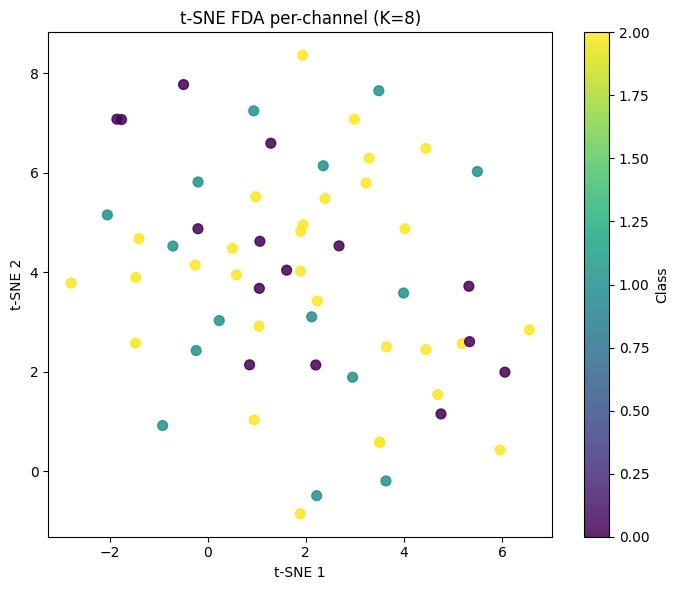

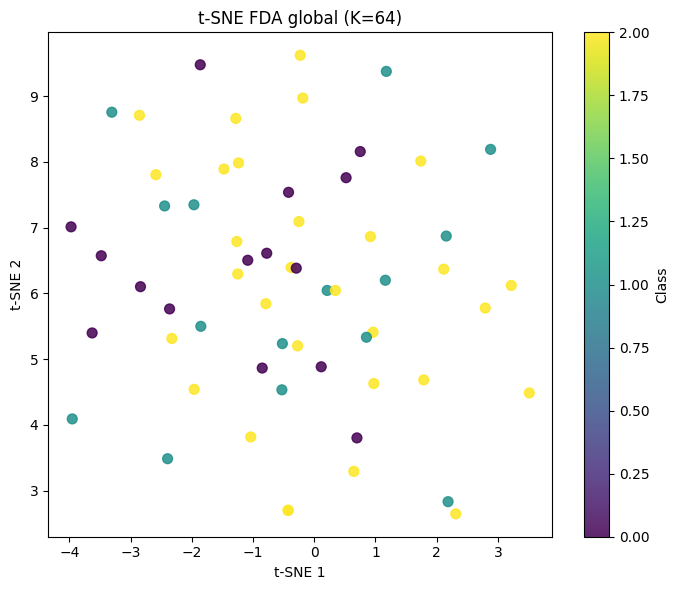

In [63]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

def tsne_plot(Xtr, ytr, Xva, yva, Xte, yte, title="t-SNE (record-level)"):
    # concatena
    X = np.concatenate([Xtr, Xva, Xte], axis=0)
    y = np.concatenate([ytr, yva, yte], axis=0)

    # standardizza
    Xz = StandardScaler().fit_transform(X)

    # PCA pre t-SNE (stabilità/velocità)
    Xp = PCA(n_components=min(30, Xz.shape[1]), random_state=0).fit_transform(Xz)

    # t-SNE
    tsne = TSNE(
        n_components=2,
        perplexity=min(15, max(5, len(X)//4)),
        init="pca",
        learning_rate="auto",
        random_state=0
    )
    X2 = tsne.fit_transform(Xp)

    plt.figure(figsize=(7,6))
    sc = plt.scatter(X2[:,0], X2[:,1], c=y, s=50, alpha=0.85)
    plt.colorbar(sc, label="Class")
    plt.title(title)
    plt.xlabel("t-SNE 1"); plt.ylabel("t-SNE 2")
    plt.tight_layout()
    plt.show()

# Esempio: dopo FDA per-canale
tsne_plot(Xtr_rec, ytr_rec, Xva_rec, yva_rec, Xte_rec, yte_rec,
          title=f"t-SNE FDA per-channel (K={K_ch})")

# Esempio: dopo FDA globale
tsne_plot(Xtr_rec_g, ytr_rec_g, Xva_rec_g, yva_rec_g, Xte_rec_g, yte_rec_g,
          title=f"t-SNE FDA global (K={K_glob})")


## t-SNE su FDA a livello window

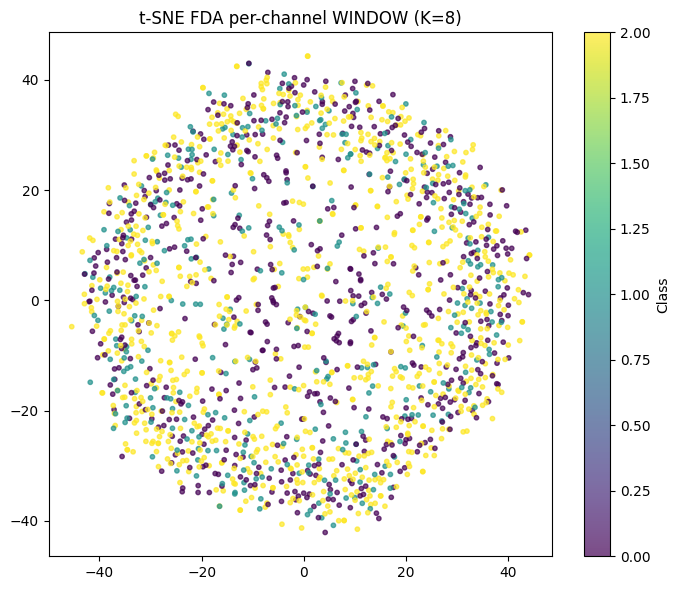

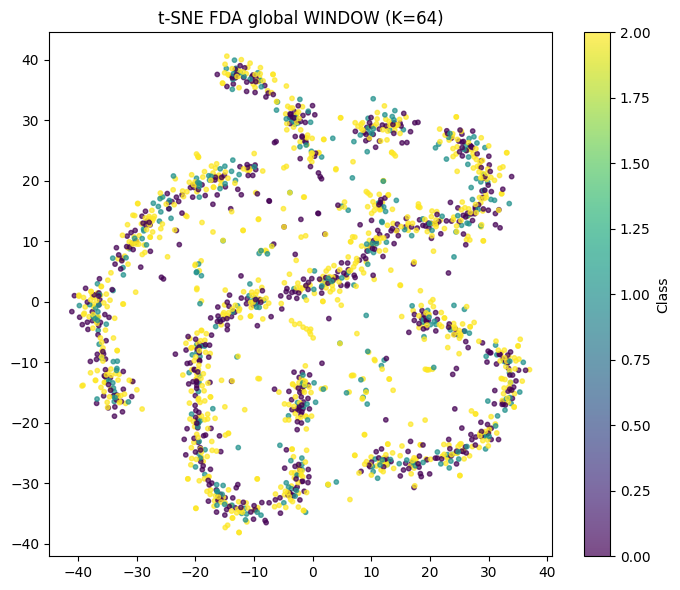

In [64]:
def tsne_plot_windows(F_w, y_w, title="t-SNE (window-level)", max_points=2000, seed=0):
    rs = np.random.RandomState(seed)
    n = len(F_w)
    idx = rs.choice(n, size=min(max_points, n), replace=False)
    X = F_w[idx]
    y = y_w[idx]

    Xz = StandardScaler().fit_transform(X)
    Xp = PCA(n_components=min(30, Xz.shape[1]), random_state=0).fit_transform(Xz)

    tsne = TSNE(
        n_components=2,
        perplexity=30,
        init="pca",
        learning_rate="auto",
        random_state=seed
    )
    X2 = tsne.fit_transform(Xp)

    plt.figure(figsize=(7,6))
    sc = plt.scatter(X2[:,0], X2[:,1], c=y, s=10, alpha=0.7)
    plt.colorbar(sc, label="Class")
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Per-canale window features
tsne_plot_windows(Ftr_w, ytr_w, title=f"t-SNE FDA per-channel WINDOW (K={K_ch})")

# Globale window features
tsne_plot_windows(Gtr_w, ytr_w, title=f"t-SNE FDA global WINDOW (K={K_glob})")
